In [221]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from kalman_vect import plot_2d_gauss, generate_sample, plot_update, plot_prediction

# The model

$\vec{X_{k+1}} = F\vec{X_{k}} +  B \vec{U_k} + \vec{W_k}$

$\vec{Z_k} = H\vec{X_k} + \vec{V_k}$

**$\vec{X}$**: The state vector.

**$\vec{Z}$**: The observation vector. 

**$\vec{W}$**: The process noise. Mean zero and covariance matrix $Q$: $W = N(0,Q)$

**$F$**: The state transition factor. See example below

**$B, \vec{U}$**: The control input model. B is a Matrix

**$H$**: Observation model. Maps the true state space into the observation space

**$V$**: Observation Noise. Mean zero and covariance matrix $R$: $V = N(0,R)$


# Generative model

## Walking robot example

$\vec{X} = \begin{bmatrix}x \\ \dot{x} \end{bmatrix} \quad
F = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix}\quad
H = \begin{bmatrix} 1 & 0 \end{bmatrix} \quad$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

$\Sigma_w = Q = \begin{bmatrix}\sigma_w^2 & 0 \\ 0 & 0 \end{bmatrix} \quad
\Sigma_v = R = \sigma_v^2 $

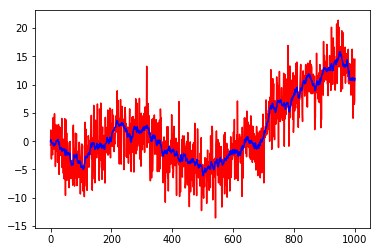

In [223]:
starting_position = 0
starting_velocity = 0.01
X_o = np.matrix([[starting_position],[starting_velocity]])
var_w = 0.1
sigma_w = np.matrix([[var_w,0],[0,0]])
var_v = 10
sigma_v = np.matrix([[var_v]])
F = np.matrix([[1,1],[0,1]])
H = np.matrix([1,0])

steps = 1000
measurements, ground_truths = generate_sample(X_o, sigma_w ,sigma_v , H, F, steps = steps)
real_positions = np.array(ground_truths).reshape(-1,2)[:,0]
real_speed = np.array(ground_truths).reshape(-1,2)[:,1]
measurements = np.array(measurements).flatten()
plt.plot(range(len(measurements)),measurements, color='r')
plt.plot(range(len(measurements)),real_positions, color='b')
plt.show()

# Update (Multiplication of N dimensional normal pdfs) - Bayes theorem -

https://www.cs.nyu.edu/~roweis/notes/gaussid.pdf

$N(c,C) = \alpha N(a,A)N(b,B) $

$ C = (A^{-1} + B^{-1})^{-1}$

$ c = CA^{-1}a + CB^{-1}b$

$a$, $b$ and $c$ are the mean vectors

$A$, $B$ and $C$ are the covariant matrices

In [224]:
def gauss_pdfs_mult(a,A,b,B):
    A_1 = np.linalg.inv(A)
    B_1 = np.linalg.inv(B)
    C = np.linalg.inv(A_1 + B_1)
    c = C.dot(A_1).dot(a) + C.dot(B_1).dot(b)
    return c, C

## Example

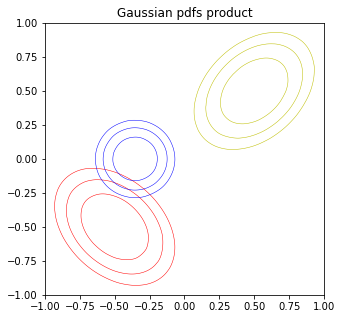

[[-0.3535]
 [ 0.    ]]


In [225]:
plt.figure(figsize = (5,5))  

zero_mean = np.matrix([[-0.5] , [-0.5]])
R = np.matrix([[1, -0.707],[0 ,1]])

mu_x = np.matrix([[0.5] , [0.5]])
sigma_x = np.matrix([[1, 0.707],[0 ,1]])
limit = 1
plot_2d_gauss(zero_mean, R, color='r', limits = [-limit,limit, -limit,limit], label = 'Gaussian A')
plot_2d_gauss(mu_x, sigma_x, color='y', limits = [-limit,limit, -limit,limit], label = 'Gaussian B')

mean, P = gauss_pdfs_mult(zero_mean, R, mu_x, sigma_x)
plot_2d_gauss(mean, P, color = 'b' , limits = [-limit,limit, -limit,limit], label = 'Gaussian C')
plt.title('Gaussian pdfs product')
plt.show()
print(mean)

## Applied to our problem

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$\large{p(X_k|Z_k) = \alpha p(Z_k|X_k)p(X_K)}$

$a = \mu_{x_k} = H^{-1}Z \quad A = H^{-1}R (H^{-1})^T \quad b=\hat{X}_{k|k-1} \quad  B = P_{k|k-1} $ 

$C = P_{k|k} \quad c=\hat{X}_{k|k}$

$P_{k|k} = \Sigma_{X_k}^{ud} = (H^TR^{-1}H + P_{k|k-1}^{-1})^{-1}$

$\hat{X}_{k|k} = \vec{\mu_x^{ud}} = P_{k|k}[H^TR^{-1}Z+P_{k|k-1}^{-1}{\hat{X}_{k|k-1}}]$

Remeber 1D kalman vector for analogy

$\mu_a = h^{-1}Z \quad \sigma_a^2 = \frac{\sigma_v^2}{h^2} \quad \mu_b = \hat{X}_{n|n-1} \quad \sigma_b^2 = p_{n|n-1}$

$\sigma_x^2 = p_{n|n}  \quad$ $\mu_x = \hat{X}_{n|n} $

In [226]:
def update(H, R, Z, X_est_prior ,P_est_prior):
    A_1 = H.T.dot(np.linalg.inv(R)).dot(H)
    P_est_prior_inv = np.linalg.inv(P_est_prior)
    
    P_est = np.linalg.inv(A_1 + P_est_prior_inv)
    
    X_est = P_est.dot(H.T.dot(np.linalg.inv(R)).dot(Z) + P_est_prior_inv.dot(X_est_prior))
    
    return X_est, P_est

## Example: Position  is observed but speed is not observed

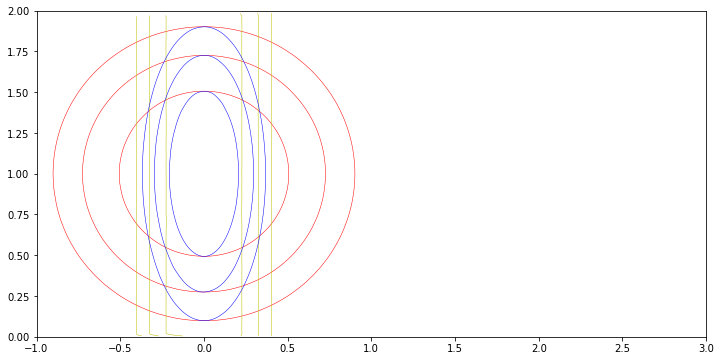

In [227]:
initial_speed_guess = 1
H = np.matrix([1, 0])
# a priori estimates
X_est_prior = np.matrix([[0] , [initial_speed_guess]])
P_est_prior = np.matrix([[5, 0],[0 ,5]])

R = np.matrix([1])

Z = H.dot(X_est_prior)
X_est_u, P_est_u = plot_update(H, R, Z, X_est_prior, P_est_prior, y_offset = initial_speed_guess, 
                               x_npts=2000, y_npts=2000)

# Prediction (Independent random vectors linear combination)

$E[A\vec{X} + \vec{Y}] = AE[\vec{X}]+E[\vec{Y}]$

$\Sigma_{AX+Y} = A\Sigma_{X}A^T + \Sigma_{Y}$

## Applied to our model

$\vec{X_{k+1}} = F\vec{X_{k}} + \vec{W}$

$\hat{X}_{k+1} = F\hat{X}_{k}$

$P_{k+1} = FP_{k}F^T + Q$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

$\hat{x_{k+1}} = \hat{x_{k}} + \Delta t \dot{X_k}$

In [228]:
def predict(F, mu_x, sigma_x, Q):
    X_est = F.dot(mu_x)
    P = F.dot(sigma_x).dot(F.T) + Q
    return X_est, P

# Examples

$\vec{X_{k+1}} = F\vec{X_{k}} +  B \vec{U_k} + \vec{W_k}$

$\vec{Z_k} = H\vec{X_k} + \vec{V_k}$

## Example 1

$\vec{X} = \begin{bmatrix}x \\ \dot{x} \end{bmatrix} \quad
F = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix}\quad
H = \begin{bmatrix} 1 & 0 \end{bmatrix} \quad$
$B \vec{U_k} = 0$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

$\Sigma_w = Q = \begin{bmatrix}\sigma_w^2 & 0 \\ 0 & 0 \end{bmatrix} \quad
\Sigma_v = R = \sigma_v^2 $

In [233]:
from kalman_vect import Kalman

In [300]:
z = 1
X_0 = [[1],[10]]
P_0 = [[infinite,0],[0,infinite]]
print(k_filter.update(z, X_0, P_0)[0])
print(k_filter.update_with_kalman_gain(z, X_0, P_0)[0])

[[ 1.]
 [10.]]
[[  1.]
 [ 10.]]


In [285]:
#print(k_filter.update_with_kalman_gain(0.1, X_0, P_0)[1])

H = np.matrix(H)
R = np.matrix(R)
P_0 = np.matrix(P_0)
S = R + H.dot(P_0).dot(H.T)
K = P_0.dot(H.T).dot(S.I)
P = (np.identity(R.shape[0]) - K.dot(H)).dot(P_est_prior)

print(np.identity(R.shape[0]))

[[ 1.]]


### Change velocity while generating and check that the model predict the velocity correctly

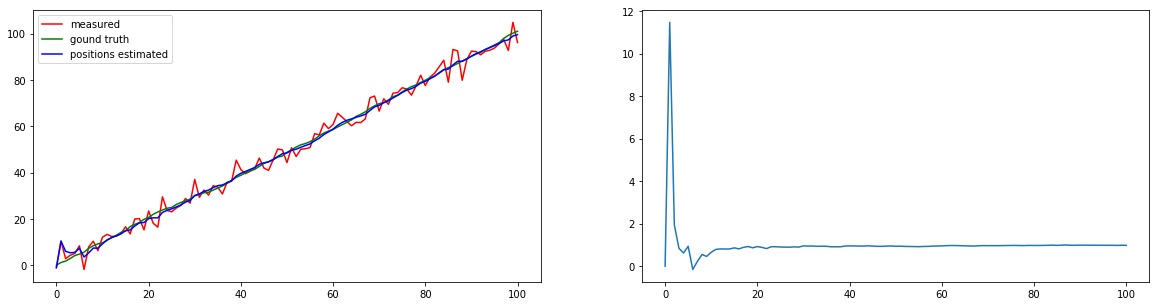

In [305]:
iterations = 100
infinite = 100000

X_0 = [[0],[0]]
P_0 = [[infinite,0],[0,infinite]]
F = [[1, 1],[0,1]]
Q = [[0.1, 0],[0,0]]
H = [1,0]
R = 10
k_filter = Kalman(X_0, P_0, H, R, F, Q)

# We use the velocity defined to generate de sample
velocity = 1
measurements, ground_truths = k_filter.generate_model_sample([[0],[velocity]], iterations=iterations)

updated_means, update_covariances, predicted_means, predicted_covariances, k_gains = k_filter.filter()

measured_positions = []
ground_truth_positions = []
positions_estimated = []
velocities_estimated = []

for i, measurement in enumerate(measurements):
    measured_positions.append(measurement[0,0])
    ground_truth_positions.append(ground_truths[i][0,0])
    positions_estimated.append(updated_means[i][0,0])
    velocities_estimated.append(updated_means[i][1,0])
    
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(measured_positions, label = 'measured', color='r')
plt.plot(ground_truth_positions, label = 'gound truth', color='g')
plt.plot(positions_estimated, label = 'positions estimated', color='b')
plt.legend()
plt.subplot(1,2,2)
plt.plot(velocities_estimated)
plt.show()

### Change parameters and see what happens

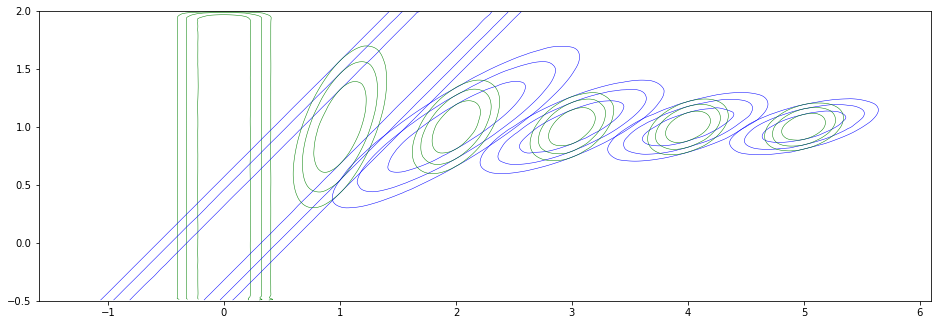

In [307]:
def plot_vect_kalman_filter(X_0, P_0, H, R, F, Q, mesurements, x_npts=2000, y_npts=2000):
    k_filter = Kalman(X_0, P_0, H, R, F, Q)
    updated_means, update_covariances, predicted_means, predicted_covariances, _ = k_filter.filter(measurements=mesurements)

    limits=[-1.5, 6, -0.5, 2]

    
    aspect_ratio=(limits[3]-limits[2])/(limits[1]-limits[0])
    graph_width = 16
    plt.figure(figsize=(graph_width,graph_width*aspect_ratio))
    plt.axes().set_aspect('equal', 'datalim')
    plot_2d_gauss(updated_means[0],update_covariances[0], x_npts=x_npts, y_npts=y_npts,
                      limits=limits, color='g')
    for iteration in range(5):
        plot_2d_gauss(predicted_means[iteration],predicted_covariances[iteration], x_npts=x_npts, y_npts=y_npts,
                      limits=limits, color='b')
        plot_2d_gauss(updated_means[iteration+1],update_covariances[iteration+1], x_npts=x_npts, y_npts=y_npts,
                          limits=limits, color='g')
        
X_0 = [[0],[0]]
P_0 = [[infinite,0],[0,infinite]]
F = [[1, 1],[0,1]]
Q = [[1, 0],[0,0]]
H = [1,0]
R = 1
mesurements = np.array([0,1,2,3,4,5,6,7,8,9])*1
plot_vect_kalman_filter(X_0, P_0, H, R, F, Q, mesurements)

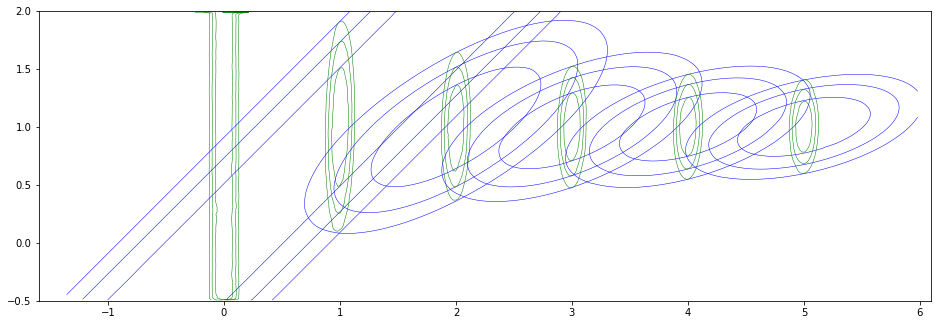

In [308]:
X_0 = [[0],[0]]
P_0 = [[infinite,0],[0,infinite]]
F = [[1, 1],[0,1]]
Q = [[5, 0],[0,0]]
H = [1,0]
R = 0.1
mesurements = np.array([0,1,2,3,4,5,6,7,8,9])*1
plot_vect_kalman_filter(X_0, P_0, H, R, F, Q, mesurements, x_npts=3000, y_npts=3000)

### What is this difference between this model and the 1-d kalman model?

This model does not assume a specific velocity, it estimates the velocity from the measured samples Z.

So it is a more general model that the 1-d model

## Example 2. What if the velocity is not constant? Acceleration constant

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \\ \ddot{x_{k+1}} \end{bmatrix} 
= \begin{bmatrix}1 & \Delta{t} & \frac{1}{2}\Delta{t}^2\\ 0 & 1 & \Delta{t} \\0&0&1 \end{bmatrix} 
\begin{bmatrix}x_{k} \\ \dot{x_{k}} \\ \ddot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 &0\end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \\ \ddot{x_{k}} \end{bmatrix} + \vec{V}$

## And what about a system that desaccelerates exponentially?

$\begin{bmatrix}x_{k+1} \\ \dot{x}_{k+1} \\ \ddot{x}_{k+1} \end{bmatrix} 
= \begin{bmatrix}1 & \Delta{t} & \frac{1}{2}\Delta{t}^2\\ 0 & 1 & \Delta{t} \\0&0& e^{-\alpha\Delta{t}}\end{bmatrix} 
\begin{bmatrix}x_{k} \\ \dot{x_{k}} \\ \ddot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 &0\end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \\ \ddot{x_{k}} \end{bmatrix} + \vec{V}$

## In 2-D?

$\begin{bmatrix} x_{1_{k+1}} \\ \dot{x}_{1_{k+1}} \\ \ddot{x}_{1_{k+1}} \\ x_{2_{k+1}} \\ \dot{x}_{2_{k+1}} \\ \ddot{x}_{2_{k+1}} \end{bmatrix}
= \begin{bmatrix}1 & \Delta{t} & \frac{1}{2}\Delta{t}^2 & 0 &0&0 \\ 0 & 1 & \Delta{t} & 0 &0&0 \\0&0& e^{-\alpha\Delta{t}} & 0 &0&0 \\
0 &0&0 & 1 & \Delta{t} & \frac{1}{2}\Delta{t}^2  \\ 0 &0&0 &0 & 1 & \Delta{t}\\0&0& 0 & 0 &0&e^{-\alpha\Delta{t}}
\end{bmatrix}
\begin{bmatrix} x_{1_k} \\ \dot{x_{1_k}} \\ \ddot{x_{1_k}} \\ x_{2_k} \\ \dot{x_{2_k}} \\ \ddot{x_{2_k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 &0&0&0&0\\0 & 0 &0&1&0&0 \end{bmatrix}
\begin{bmatrix} x_{1_k} \\ \dot{x_{1_k}} \\ \ddot{x_{1_k}} \\ x_{2_k} \\ \dot{x_{2_k}} \\ \ddot{x_{2_k}} \end{bmatrix} + \vec{V}$

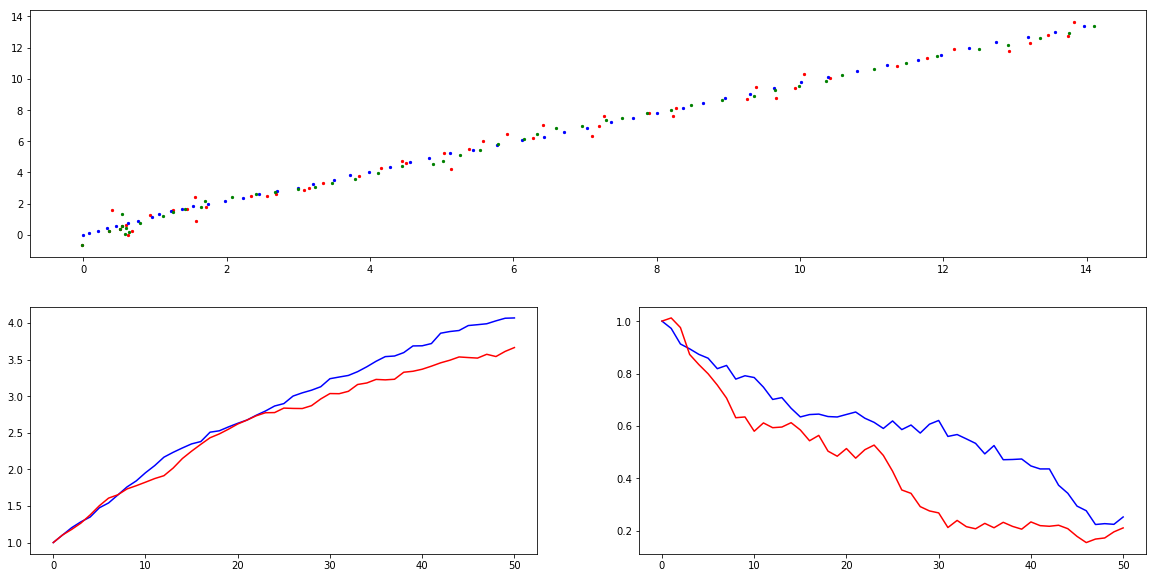

In [310]:
iterations = 50
infinite = 100000
deltaT = 0.1
alpha = 0.3
accel_factor = np.exp(-alpha*deltaT)
sigma_w = 0.001
sigma_v = 0.1

X_0 = [[0],[0],[0],[0],[0],[0]]

P_0 = [[infinite,0,0,0,0,0],
       [0,infinite,0,0,0,0],
       [0,0,infinite,0,0,0],
       [0,0,0,infinite,0,0],
       [0,0,0,0,infinite,0],
       [0,0,0,0,0,infinite]]

F = [[1, deltaT, 0.5*(deltaT**2),0,0,0],
     [0, 1, deltaT, 0,0,0],
     [0, 0, accel_factor,0,0,0],
     [0,0,0,1, deltaT, 0.5*(deltaT**2)],
     [0,0,0,0, 1, deltaT],
     [0,0,0,0, 0, accel_factor],
    ]
Q = [[sigma_w, 0, 0, 0, 0, 0],
     [0, sigma_w, 0, 0, 0, 0],
     [0, 0, sigma_w, 0, 0, 0],
     [0, 0, 0, sigma_w, 0, 0],
     [0, 0, 0, 0, sigma_w, 0],
     [0, 0, 0, 0, 0, sigma_w],
    ]
H = [[1,0,0,0,0,0],
     [0,0,0,1,0,0]]
R = [[sigma_v,0],
     [0,sigma_v]]

k_filter_2d = Kalman(X_0, P_0, H, R, F, Q)
#print(k_filter_2d)
# We use the velocity defined to generate de sample
pos_x = 0
pos_y = 0
velocity_x = 1
velocity_y = 1
accel_x = 1
accel_y = 1
generator_initial_conditions = [[pos_x],[velocity_x],[accel_x],[pos_y],[velocity_y],[accel_y]]
measurements, ground_truths = k_filter_2d.generate_model_sample(generator_initial_conditions, iterations=iterations)

updated_means, update_covariances, predicted_means, predicted_covariances, _ = k_filter_2d.filter()

measured_positions_x = []
measured_positions_y = []
ground_truth_positions_x = []
ground_truth_positions_y = []
ground_truth_velocity_x = []
ground_truth_velocity_y = []
ground_truth_accel_x = []
ground_truth_accel_y = []
estimated_x = []
estimated_y = []

for i, measurement in enumerate(measurements):
    measured_positions_x.append(measurement[0,0])
    measured_positions_y.append(measurement[1,0])
    ground_truth_positions_x.append(ground_truths[i][0,0])
    ground_truth_positions_y.append(ground_truths[i][3,0])
    ground_truth_velocity_x.append(ground_truths[i][1,0])
    ground_truth_velocity_y.append(ground_truths[i][4,0])
    ground_truth_accel_x.append(ground_truths[i][2,0])
    ground_truth_accel_y.append(ground_truths[i][5,0])
    estimated_x.append(updated_means[i][0,0])
    estimated_y.append(updated_means[i][3,0])
    

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.scatter(measured_positions_x, measured_positions_y, s=5, color='r')
plt.scatter(ground_truth_positions_x, ground_truth_positions_y, s=5, color='b')
plt.scatter(estimated_x, estimated_y, s=5, color='g')

plt.subplot(2,2,3)
plt.plot(ground_truth_velocity_x,color='b')
plt.plot(ground_truth_velocity_y,color='r')
plt.subplot(2,2,4)
plt.plot(ground_truth_accel_x,color='b')
plt.plot(ground_truth_accel_y,color='r')
plt.show()

Sensor fusion
https://www.slideshare.net/antoniomorancardenas/data-fusion-with-kalman-filtering
https://home.wlu.edu/~levys/kalman_tutorial/kalman_13.html
